<a href="https://colab.research.google.com/github/darkfapper/Pandoras_Box/blob/main/Pandora's_Box_Example_Bayesian_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpyro pycaret pyro-ppl

In [2]:
import pandas as pd
import numpy as np
import zipfile
## Rede Neural Bayesiana
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO , JitTrace_ELBO , Predictive
from pyro.infer.autoguide import (AutoDiagonalNormal , AutoMultivariateNormal ,
 AutoLaplaceApproximation , AutoNormal , AutoNormalizingFlow , AutoRegressiveMessenger,
 AutoNormalMessenger , AutoIAFNormal , AutoLowRankMultivariateNormal)
from pyro.distributions.transforms import block_autoregressive, iterated, affine_autoregressive , spline_autoregressive , affine_autoregressive , householder , sylvester
from tqdm.auto import trange
from scipy import stats as st
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO , JitTrace_ELBO , Predictive
from pyro.infer.autoguide import (AutoDiagonalNormal , AutoMultivariateNormal ,
 AutoLaplaceApproximation , AutoNormal , AutoNormalizingFlow , AutoRegressiveMessenger,
 AutoNormalMessenger , AutoIAFNormal , AutoLowRankMultivariateNormal)
from pyro.distributions.transforms import block_autoregressive, iterated, affine_autoregressive , spline_autoregressive , affine_autoregressive , householder , sylvester
from pyro.infer.autoguide.gaussian import AutoGaussianFunsor
from tqdm.auto import trange
from scipy import stats as st
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score , roc_auc_score , brier_score_loss
from sklearn import datasets
from pyro.infer import MCMC, NUTS
import arviz as az
from functools import partial
from pyro.infer.reparam import NeuTraReparam
import pyro.poutine as poutine
from pyro.distributions.transforms import (neural_autoregressive ,spline_autoregressive , affine_autoregressive ,
affine_coupling , planar , conditional_affine_autoregressive, conditional_neural_autoregressive , ConditionalAffineAutoregressive)
torch.set_printoptions(precision=5,sci_mode=False)
# Set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(42)
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()
from scipy import stats as st

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#read winrar file
dir_zip = "/content/drive/MyDrive/playground-series-s3e3.zip"
with zipfile.ZipFile(dir_zip, 'r') as zip_ref:
    zip_ref.extractall("")


In [5]:
df = pd.read_csv('/content/train.csv')
df
target='Attrition'

In [6]:
exp.setup(data=df, target=target)

,Description,Value
0,Session id,1974
1,Target,Attrition
2,Target type,Binary
3,Original data shape,"(1677, 35)"
4,Transformed data shape,"(1677, 54)"
5,Transformed train set shape,"(1173, 54)"
6,Transformed test set shape,"(504, 54)"
7,Ordinal features,2
8,Numeric features,26
9,Categorical features,8


In [7]:
# exp.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:35:25
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8935,0.8329,0.2714,0.6107,0.3635,0.3184,0.3531,0.1950
lda,Linear Discriminant Analysis,0.8875,0.8195,0.2857,0.5729,0.3757,0.3217,0.3478,0.0740
lr,Logistic Regression,0.8858,0.7941,0.1500,0.5855,0.2284,0.1921,0.2459,0.7580
ridge,Ridge Classifier,0.8849,0.0000,0.0857,0.5800,0.1424,0.1200,0.1854,0.0690
rf,Random Forest Classifier,0.8823,0.8200,0.0500,0.4900,0.0869,0.0717,0.1311,0.2070
ada,Ada Boost Classifier,0.8815,0.8202,0.2857,0.5606,0.3516,0.2958,0.3239,0.1240
xgboost,Extreme Gradient Boosting,0.8815,0.8089,0.2071,0.5233,0.2871,0.2375,0.2710,0.1020
et,Extra Trees Classifier,0.8798,0.8363,0.0857,0.4700,0.1411,0.1109,0.1599,0.1540
knn,K Neighbors Classifier,0.8653,0.5685,0.0071,0.0333,0.0118,-0.0166,-0.0231,0.0750
dt,Decision Tree Classifier,0.8201,0.5829,0.2714,0.2656,0.2657,0.1645,0.1655,0.0680


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
xgb = exp.create_model("xgboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8898,0.8221,0.1429,0.6667,0.2353,0.2019,0.2737
1,0.8814,0.7727,0.0714,0.5000,0.1250,0.0983,0.1549
2,0.8644,0.7802,0.2143,0.3750,0.2727,0.2040,0.2138
3,0.8974,0.7906,0.2857,0.6667,0.4000,0.3536,0.3918
4,0.8889,0.8731,0.2143,0.6000,0.3158,0.2698,0.3127
5,0.8462,0.8523,0.2143,0.3000,0.2500,0.1669,0.1699
6,0.8718,0.7323,0.0714,0.3333,0.1176,0.0787,0.1068
7,0.8974,0.7795,0.2857,0.6667,0.4000,0.3536,0.3918
8,0.8803,0.8155,0.2143,0.5000,0.3000,0.2459,0.2725


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
final_model = exp.finalize_model(xgb)
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['id', 'Age', 'DailyRate',
                                             'DistanceFromHome', 'Education',
                                             'EmployeeCount',
                                             'EnvironmentSatisfaction',
                                             'HourlyRate', 'JobInvolvement',
                                             'JobLevel', 'JobSatisfaction',
                                             'MonthlyIncome', 'MonthlyRate',
                                             'NumCompaniesWorked',
                                             'PercentSalaryHike',
                                             'PerformanceRatin...
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='binary:logistic', ...))],
         verbose=False)

In [10]:
pipeline = exp.get_config("pipeline")
dataset = exp.get_config("dataset")
baseline_predict = dataset.assign(predict = final_model.predict(dataset.drop(columns = [target])))

In [11]:
dataset_processed = pipeline.transform(dataset)
dataset_processed.dtypes

id                                   float64
Age                                  float64
BusinessTravel_Travel_Rarely         float64
BusinessTravel_Travel_Frequently     float64
BusinessTravel_Non-Travel            float64
DailyRate                            float64
Department_Research & Development    float64
Department_Sales                     float64
Department_Human Resources           float64
DistanceFromHome                     float64
Education                            float64
EducationField_Medical               float64
EducationField_Marketing             float64
EducationField_Life Sciences         float64
EducationField_Other                 float64
EducationField_Human Resources       float64
EducationField_Technical Degree      float64
EmployeeCount                        float64
EnvironmentSatisfaction              float64
Gender                               float64
HourlyRate                           float64
JobInvolvement                       float64
JobLevel  

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset_processed.drop(columns = [target]), dataset_processed[target].astype('category').cat.codes
                                                    , test_size=0.2, random_state=42)

In [14]:
y_train

1546    0
188     0
1061    0
859     0
1012    0
       ..
1326    0
128     1
81      1
570     0
1327    0
Length: 1341, dtype: int8

In [15]:
# Convert data to PyTorch tensors
X_train_mc = torch.from_numpy(X_train.values).float()
y_train_mc = torch.from_numpy(y_train.values).float()

X_test_mc = torch.from_numpy(X_test.values).float()
y_test_mc = torch.from_numpy(y_test.values).float()

batch_size = 512

In [16]:
trainloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=True, batch_size=batch_size)
validloader = DataLoader(list(zip(X_train_mc, y_train_mc)), shuffle=True, batch_size=len(X_train_mc))
testloader = DataLoader(list(zip(X_test_mc, y_test_mc)), shuffle=True, batch_size=len(X_test_mc))
loaders_dict = {"train": trainloader, "valid": validloader, "test": testloader}

In [17]:


def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=0)


def predictive_entropy(mc_preds):
    """
    Compute the entropy of the mean of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return entropy(np.mean(mc_preds, axis=0))


def mutual_information(mc_preds):
    """
    Compute the difference between the entropy of the mean of the
    predictive distribution and the mean of the entropy.
    """
    mutual_info = entropy(np.mean(mc_preds, axis=0)) - np.mean(entropy(mc_preds),
                                                               axis=0)
    return mutual_info

def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}


In [18]:
class BNN(PyroModule):
    def __init__(self, in_dim=X_train_mc.shape[1], out_dim=1, hid_dim=48, n_hid_layers=3, prior_scale=10.):
        super().__init__()

        self.activation = nn.LeakyReLU()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # x = x.reshape(x.shape[0], -1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        yhat = torch.nn.functional.sigmoid(mu)
        with pyro.plate("data", x.shape[0]):
            probs = pyro.deterministic("probs",yhat)
            ## Incerteza Aletorica
            obs = pyro.sample("obs", dist.Binomial(logits=mu), obs=y)
        return mu

def func_metrics(samples,y,is_multi = False):

  if isinstance(y,torch.Tensor):
    y = y.detach().numpy()
  if isinstance(samples,dict):
    _preds = st.mode(samples["obs"].detach().numpy()).mode.ravel()
    ## Existem valores negativos e acima de 1 (provavel erro de maquina)
    _preds_probs = np.clip(samples["probs"].detach().numpy(),0.00001,1)
    mean = np.mean(_preds_probs,axis = 0)
  else:
    _preds_probs = samples
    mean = np.mean(_preds_probs,axis = 0)

    _preds = np.where(mean > 0.5,1,0)
  pred_entropy = predictive_entropy(_preds_probs)
  mutual_info = mutual_information(_preds_probs)
  acc = accuracy_score(y,_preds)
  f1 = f1_score(y,_preds)
  auc = roc_auc_score(y,_preds)
  brier = brier_score_loss(y,mean)

  return pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"predictive_entropy":pred_entropy,
                       "mutual_information":mutual_info,"brier_score":brier},index = [0])

def variational_train(model,guide,loaders_dict,epochs = 500,num_samples = 150):
  pyro.clear_param_store()
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
    progress_bar.set_description(f"ELBO: {loss}")
  losses_ = np.array(losses)

  q75 = np.quantile(losses_,q = 0.75)
  q25 = np.quantile(losses_,q = 0.25)

  IQR = q75 - q25
  lower = q25 - 1.5*IQR
  upper = q75 + 1.5*IQR

  losses_ = losses_[losses_ > lower]
  losses_ = losses_[losses_ < upper]
  plt.plot(range(1,len(losses_)+1),losses_)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    # X = X.cuda()
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"hist_train":losses,"svi":svi}

def neural_mcmc_train(model,loaders_dict,guide,epochs = 50,num_samples = 50,warmup_steps = 10 ):
  pyro.clear_param_store()
  ## First Step: Variacional Inference
  optimizer = pyro.optim.Adam({"lr": 0.001})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

  progress_bar = trange(epochs)
  losses = []
  for epoch in progress_bar:
    for X_batch, y_batch in loaders_dict["train"]:
      loss = svi.step(X_batch, y_batch)
      loss = loss/len(loaders_dict["train"])
      losses.append(loss)
  losses_ = np.array(losses)
  q75 = np.quantile(losses_,q = 0.75)
  q25 = np.quantile(losses_,q = 0.25)

  IQR = q75 - q25
  lower = q25 - 1.5*IQR
  upper = q75 + 1.5*IQR

  losses_ = losses_[losses_ > lower]
  losses_ = losses_[losses_ < upper]
  plt.plot(range(1,len(losses_)+1),losses_)
  plt.xlabel("Epochs")
  plt.ylabel("ELBO")
  plt.show()

  ## Second Step: Markov Chain Monte Carlo
  X_mc , y_mc = next(iter(loaders_dict["valid"]))
  neutra = NeuTraReparam(guide.requires_grad_(False))
  #neutra = NeuTraReparam(guide)
  model = poutine.reparam(model,config=lambda _: neutra)
  nuts_kernel = NUTS(model, jit_compile=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X_mc, y_mc)
  print(mcmc.summary())
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X_mc)
  prior = Predictive(model, num_samples=num_samples)(X_mc)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model, guide=guide,num_samples=num_samples)
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = str(guide)
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"viz_data": pyro_data,"hist_train":losses,"svi":svi}



def mcmc_train(model,loaders_dict,num_samples = 25,warmup_steps = 10):

  """
  NUTS + MCMC
  """

  pyro.clear_param_store()
  X_mc , y_mc = next(iter(loaders_dict["valid"]))
  nuts_kernel = NUTS(model, jit_compile=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples,warmup_steps=warmup_steps)
  mcmc.run(X_mc, y_mc)
  print(mcmc.summary())
  predictive = Predictive(model, posterior_samples=mcmc.get_samples(num_samples))

  posterior_samples = mcmc.get_samples(num_samples)
  posterior_predictive = Predictive(model, posterior_samples)(X_mc)
  prior = Predictive(model, num_samples=num_samples)(X_mc)
  pyro_data = az.from_pyro(mcmc,prior=prior,posterior_predictive=posterior_predictive)
  az.plot_trace(pyro_data)

  ## Avaliação da Predição

  list_metrics = []
  predictive = Predictive(model,posterior_samples=mcmc.get_samples(num_samples))
  for name_set, loader in without_keys(loaders_dict,"train").items():
    X , y = next(iter(loader))
    samples = predictive(X)
    metrics = func_metrics(samples,y)
    metrics["guide"] = "MCMC"
    metrics["model"] = str(model)
    metrics["name_set"] = name_set
    list_metrics.append(metrics)
  metrics_full = pd.concat(list_metrics,axis = 0)

  return {"predictive":predictive ,"metrics":metrics_full ,"viz_data": pyro_data,"hist_train":None}


def deterministic_train(net, loaders_dict):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    losses = []
    progress_bar = trange(500)
    for _ in progress_bar:
      for x_train, y_train in loaders_dict["train"]:
        optimizer.zero_grad()
        loss = criterion(y_train.float(), net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
        losses.append(loss)

    ## Avaliação da Predição

    net.eval()
    list_metrics = []
    for name_set, loader in without_keys(loaders_dict,"train").items():
      X , y = next(iter(loader))
      preds = net(X)
      acc = accuracy_score(y,preds)
      f1 = f1_score(y,preds)
      auc = roc_auc_score(y,preds)
      brier = brier_score_loss(y,preds)
      metrics = pd.DataFrame({"accuracy":acc,"f1":f1,"auc":auc,"brier_score":brier},index = [0])
      metrics["model"] = str(net)
      metrics["name_set"] = name_set
      metrics["guide"] = "deterministic"
      list_metrics.append(metrics)
    metrics_full = pd.concat(list_metrics,axis = 0)



    return {"predictive": net , "metrics":metrics_full,"hist_train": losses}

In [19]:
list_results = []

  0%|          | 0/150 [00:00<?, ?it/s]

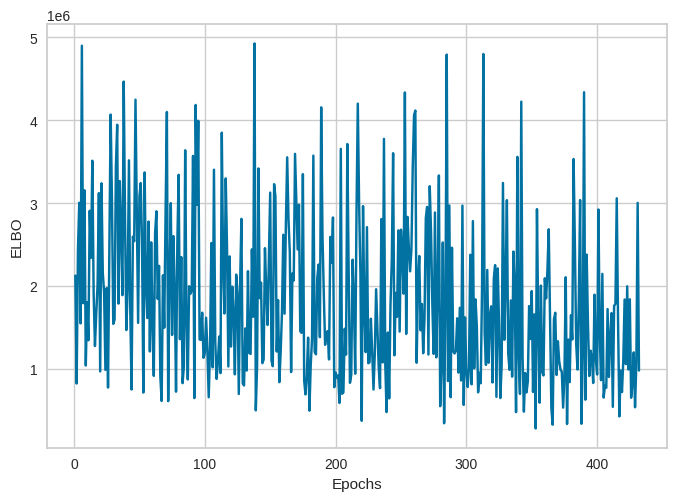

,accuracy,f1,auc,predictive_entropy,mutual_information,brier_score,guide,model,name_set
0,0.883669,0.0,0.5,378.494690,378.492113,0.113951,AutoDiagonalNormal(),BNN(\n (activation): LeakyReLU(negative_slope...,valid
0,0.869048,0.0,0.5,93.858246,93.855879,0.121439,AutoDiagonalNormal(),BNN(\n (activation): LeakyReLU(negative_slope...,test


In [20]:
## Baseline
model = BNN()
guide = AutoDiagonalNormal(model)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 25)
# aux = neural_mcmc_train(model,loaders_dict)
list_results.append(aux)
aux["metrics"]

  0%|          | 0/150 [00:00<?, ?it/s]

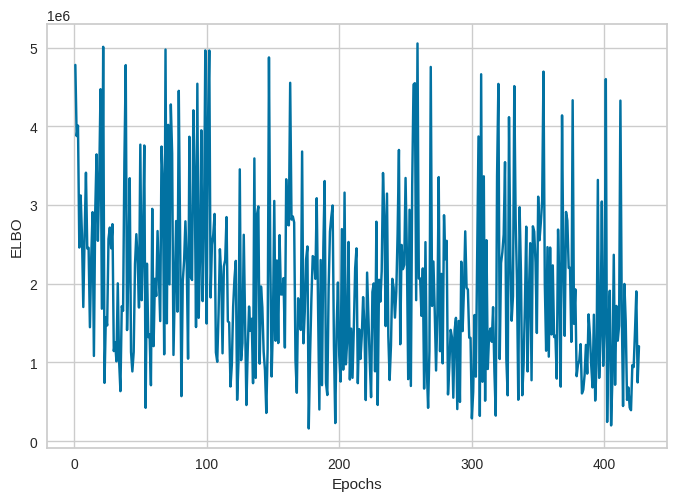

,accuracy,f1,auc,predictive_entropy,mutual_information,brier_score,guide,model,name_set
0,0.883669,0.0,0.5,330.123138,330.107557,0.098958,AutoLowRankMultivariateNormal(),BNN(\n (activation): LeakyReLU(negative_slope...,valid
0,0.869048,0.0,0.5,84.028770,84.012291,0.113109,AutoLowRankMultivariateNormal(),BNN(\n (activation): LeakyReLU(negative_slope...,test


In [21]:
## Baseline
model = BNN()
guide = AutoLowRankMultivariateNormal(model)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
# aux = neural_mcmc_train(model,loaders_dict)
list_results.append(aux)
aux["metrics"]

  0%|          | 0/150 [00:00<?, ?it/s]

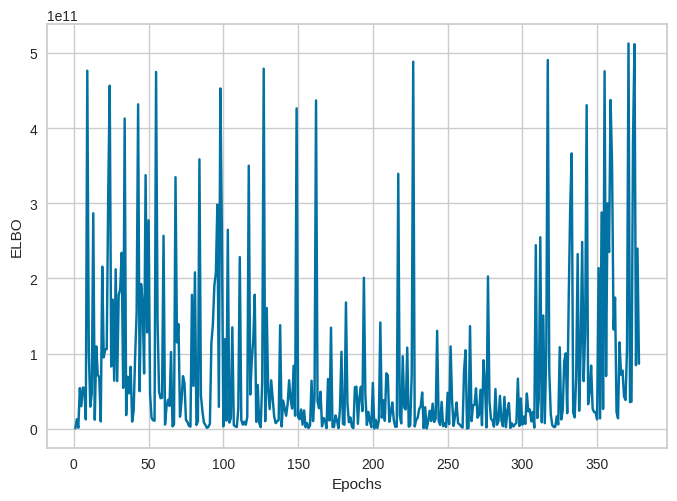

,accuracy,f1,auc,predictive_entropy,mutual_information,brier_score,guide,model,name_set
0,0.883669,0.0,0.5,293.448914,293.433280,0.101390,AutoIAFNormal(\n (transform): ComposeTransfor...,BNN(\n (activation): LeakyReLU(negative_slope...,valid
0,0.869048,0.0,0.5,78.166077,78.150599,0.114023,AutoIAFNormal(\n (transform): ComposeTransfor...,BNN(\n (activation): LeakyReLU(negative_slope...,test


In [22]:
model = BNN()
guide = AutoIAFNormal(model)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
# aux = neural_mcmc_train(model,loaders_dict)
list_results.append(aux)
aux["metrics"]

  0%|          | 0/150 [00:00<?, ?it/s]

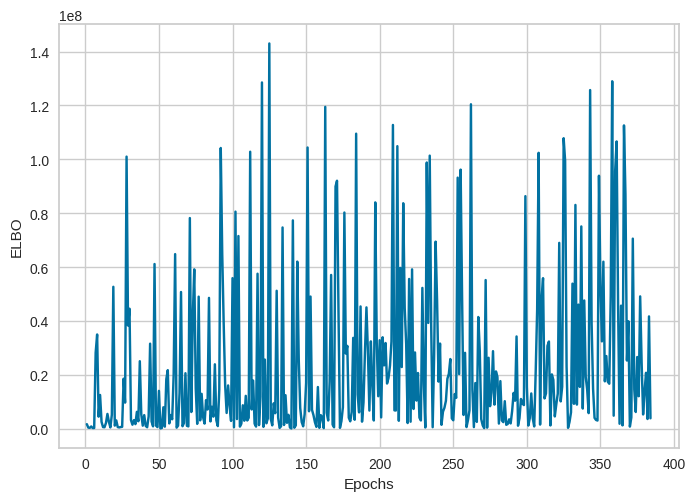

,accuracy,f1,auc,predictive_entropy,mutual_information,brier_score,guide,model,name_set
0,0.883669,0.0,0.5,447.692566,447.678862,0.114499,AutoNormalizingFlow(\n (transform): BlockAuto...,BNN(\n (activation): LeakyReLU(negative_slope...,valid
0,0.869048,0.0,0.5,118.995438,118.982878,0.134644,AutoNormalizingFlow(\n (transform): BlockAuto...,BNN(\n (activation): LeakyReLU(negative_slope...,test


In [23]:
model = BNN()
transform_init = partial(block_autoregressive,hidden_factors = [4])
guide = AutoNormalizingFlow(model,init_transform_fn=transform_init)
aux = variational_train(model,guide,loaders_dict,epochs = 150,num_samples = 150)
# aux = neural_mcmc_train(model,loaders_dict)
list_results.append(aux)
aux["metrics"]